In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
%matplotlib inline

In [3]:
def fileI(filename):
    tmp = []
    f = open(filename,'r');
    lines = f.readlines()
    for line in lines:
        tmp.append(line);
    out=np.zeros([len(tmp),5]);
    for i in range(len(out)):
        out[i,:] = np.array(tmp[i].split()).astype(np.float)
    return out;

In [4]:
# SDOF Transient Response (Smallwood)
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
# out_opt : 1 = absolute acceleration / 2 = relative displacement
def SDOF_smallwood(th_in,dt,fn,zeta,out_opt):
    
    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    a, b = np.zeros(3), np.zeros(3);
    E=np.exp(-zeta*wn*dt);
    E2=np.exp(-2*zeta*wn*dt);
    K=wd*dt;
    C=E*np.cos(K);
    P=2*zeta**2-1
    S=E*np.sin(K);
    Sp = S/K;
    if out_opt ==1:
        b[0] = 1 - Sp;
        b[1] = 2*(Sp-C);
        b[2] = E**2 - Sp;
        a[0] = 1;
        a[1] = -2*C;
        a[2] = E**2;
        th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    else:
        a[0]=1         
        a[1]=-2*C
        a[2]=+E**2    
        
        b00=2*zeta*(C-1)
        b01=S*wn/wd*P
        b02=wn*dt
            
        b10=-2*wn*dt*C
        b11= 2*zeta*(1-E2)
        b12=-2*b01   
    
        b20=(2*zeta+wn*dt)*E2
        b21= b01
        b22=-2*zeta*C               
            
        b[0]=b00+b01+b02
        b[1]=b10+b11+b12
        b[2]=b20+b21+b22
            
        b=-b/(wn**3*dt)
        
        th_out=lfilter(b, a, th_in, axis=-1, zi=None);
        th_out *=386.4;
    return th_out;       

In [5]:
## SRS (Smallwood Method)
def srs_sw(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= max(abs(SDOF_smallwood(th,dt,ft[i],dr,1)));
    return ft,rs;

In [6]:
## SRS (Smallwood Method) - Pseudo Acceleration Output
def srs_sw_pa(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= ((2*np.pi*ft[i])**2)*max(abs((SDOF_smallwood(th,dt,ft[i],dr,2))))/386.4;  
    return ft,rs;

/data/user/0/ru.iiec.pydroid3/cache/ipykernel_10339/2418606376.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[i,:] = np.array(tmp[i].split()).astype(np.float)


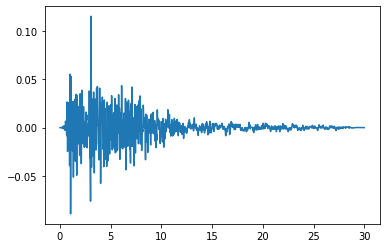

In [7]:
# Read Acc. th
data = fileI('RSN454_MORGAN_GIL067.AT2');
th = np.zeros(len(data)*5);
idx = 0;
for i in range(len(data)):
    for j in range(5):
        th[idx] = data[i,j];
        idx += 1;
dt = 0.005;
N = len(th);
tmax = dt*N;
time = np.arange(0,tmax,dt);
plt.plot(time,th);

In [8]:
Nt = len(th); tf = max(time); df = 1/tf;
fmax = df*Nt/2; Nf = int(Nt/2);
freq_table = np.arange(df,fmax+df,df);

In [10]:
freq,rs = srs_sw_pa(freq_table,th,dr=0.05,dt=dt)

In [11]:
# RG 1.60
ft = np.array([0.10,  2.50, 9.00, 33.0, 100.0]);  # frequency table
rt = np.array([0.07,  3.13, 2.61,  1.0,   1.0]);  # response spectrum table

In [12]:
# log-log interp
freq_spec = np.copy(freq_table);
resp_spec = 10**np.interp(np.log10(freq_spec),np.log10(ft),np.log10(rt));
resp_spec_u = resp_spec*1.3;
resp_spec_l = resp_spec/1.1;

In [13]:
th *= max(resp_spec/rs)

In [15]:
freq,rs = srs_sw_pa(freq_table,th,dr=0.05,dt=dt)

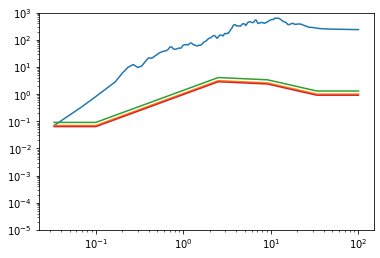

In [18]:
plt.loglog(freq,rs);
plt.loglog(freq_spec,resp_spec);
plt.loglog(freq_spec,resp_spec_u);
plt.loglog(freq_spec,resp_spec_l);
plt.ylim(1e-5,1e3);

In [19]:
def Psi(m,n,k,t):
    out = (np.exp(1j*2*n*np.pi*(t-k/(n-m)))-np.exp(1j*2*m*np.pi*(t-k/(n-m)))) / (1j*2*(n-m)*np.pi*(t-k/(n-m)));
    np.nan_to_num(out, copy=False)
    return out;

In [20]:
def a(m,n,k,time,th):
    return sum(th*Psi(m,n,k,time/tf));

In [23]:
zeta=0.05;
## Step 1
R = np.zeros(len(rs));
for i in range(len(rs)):
    R[i] = min(rs[i]/resp_spec_l[i],resp_spec_u[i]/rs[i]);
j_worst = np.argmin(R); f_worst = freq[j_worst]; 
resp = SDOF_smallwood(th,dt,f_worst,zeta,1); tau_worst = time[np.argmax(abs(resp))];

In [24]:
## Step 2
Nf_min = 30;  # 임의 설정
B = (Nf_min-1)*df;
m = j_worst-int(Nf_min/2)
n = j_worst+int(Nf_min/2)
fm = freq[m]
fn = freq[n]

In [25]:
## Step 3
dtau = 3/(zeta*f_worst*2*np.pi);
k1 = int(((tau_worst-dtau)/tf)*(n-m));
k2 = int((tau_worst/tf)*(n-m))+1;
new_th = np.zeros(len(th));
for j in range(len(time)):
    t = time[j]/tf;
    out = 0;
    for k in range(k1,k2):
        out += 2*np.real(a(m,n,k,time,th)*Psi(m,n,k,t));
    new_th[j] = out;

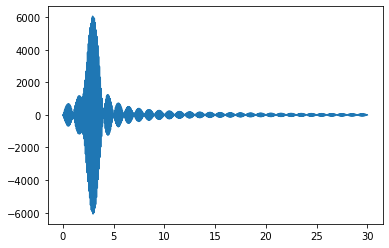

In [26]:
plt.plot(time,new_th);

In [27]:
## Step 4
resp1 = SDOF_smallwood(new_th,dt,f_worst,zeta,1);
Pl = resp*resp1;
lmax = np.argmax(Pl);

In [28]:
## Step 5
if rs[j_worst] < resp_spec[j_worst]:
    AT = resp_spec_l*1.05;
else:
    AT = resp_spec_u*0.95;
alpha = (AT-resp[lmax]) / resp1[lmax];